In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def weighted_global_efficiency(G, weight):
    """
    Returns the average weighted global efficiency of the graph,
    with flow weights normalized.

    The efficiency considers the multiplicative inverse of the shortest path
    distance between the nodes, where weights represent flow or traffic.

    Parameters
    ----------
    G : :class:`networkx.Graph`
        An undirected graph for which to compute the average weighted global efficiency.
    weight : str
        The edge attribute used as the weight for both passenger flow and shortest path computation.

    Returns
    -------
    float
        The average weighted global efficiency of the graph.

    Notes
    -----
    The weight is normalized across the entire network, representing the relative importance of flow.
    """
    n = len(G)
    denom = n * (n - 1)
    if denom == 0:  # If there are fewer than 2 nodes, return 0
        return 0

    # Step 1: Normalize weights (representing flow)
    total_weight = sum(d.get(weight, 0) for _, _, d in G.edges(data=True))
    if total_weight == 0:  # Avoid division by zero if total flow is zero
        raise ValueError("Total weight (flow) is zero. Cannot normalize weights.")

    # Add normalized weight to edge attributes
    for u, v, data in G.edges(data=True):
        data['normalized_weight'] = data.get(weight, 0) / total_weight

    # Step 2: Compute all-pairs shortest paths using the inverse of normalized weights
    length_dict = dict(nx.all_pairs_dijkstra_path_length(
        G, weight=lambda u, v, d: 1 / d['normalized_weight'] if d['normalized_weight'] > 0 else float('inf')
    ))

    # Step 3: Calculate global efficiency
    g_eff = 0
    for u in G:
        for v in G:
            if u != v and v in length_dict[u]:
                distance = length_dict[u][v]
                if distance > 0:  # Avoid division by zero
                    g_eff += 1 / distance

    return g_eff / denom

In [ ]:
import os
import pandas as pd
import networkx as nx

def process_network_efficiency(folder_path, weighted_global_efficiency_func):

    """
    Reads the start and result files in the specified folder and calculates network efficiency and the differences.

    Parameters:
        folder_path (str): The path to the folder containing the start and result files.
        weighted_global_efficiency_func (func): A predefined function for calculating weighted global efficiency.

    Returns:
        pd.DataFrame: A DataFrame containing the efficiency differences between the result network and the start network.
    """

    efficiency_results = []
    eff_original = None

    def ensure_numeric_weights(G, weight='weight'):
        for u, v, data in G.edges(data=True):
            if weight in data:
                try:
                    data[weight] = float(data[weight])
                except ValueError:
                    print(f"Edge ({u}, {v}) has a non-numeric weight: {data[weight]}")
                    data[weight] = 1.0
            else:
                data[weight] = 1.0

    start_file = None
    for file_name in os.listdir(folder_path):
        if file_name.startswith("start") and file_name.endswith(".csv"):
            start_file = file_name
            break

    if start_file is None:
        raise ValueError("No start file found in the folder. Please include at least one start file.")

    # process 'start' file
    #print(f"Processing start file: {start_file}")
    start_file_path = os.path.join(folder_path, start_file)
    start_network = pd.read_csv(start_file_path)
    G_original_7 = nx.from_pandas_edgelist(
        start_network,
        source='Source Station',
        target='Target Station',
        edge_attr=['Weight']
    )
    ensure_numeric_weights(G_original_7, weight='Weight')
    eff_original = weighted_global_efficiency_func(G_original_7, 'Weight')
    print(f"Start network efficiency: {eff_original}")

    # process 'result' files
    for file_name in os.listdir(folder_path):
        if file_name.startswith("result") and file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            #print(f"Processing result file: {file_name}")

            result_network = pd.read_csv(file_path)
            result_network = result_network[~result_network.apply(
                lambda x: x.astype(str).str.contains('Green Park').any(), axis=1)]

            #  Build networks
            G_result = nx.from_pandas_edgelist(
                result_network,
                source='Source Station',
                target='Target Station',
                edge_attr=['Weight']
            )

            ensure_numeric_weights(G_result, weight='Weight')

            # calculate efficiency
            eff_result = weighted_global_efficiency_func(G_result, 'Weight')

            # calculate efficiency difference
            efficiency_results.append({
                'Result File': file_name,
                'Efficiency (Result)': eff_result,
                'Efficiency (Start)': eff_original,
                'Efficiency Difference': eff_result - eff_original
            })
            #print(f"Processed {file_name}: Efficiency Difference = {eff_result - eff_original}")

    efficiency_df = pd.DataFrame(efficiency_results)
    # 转换为DataFrame    #efficiency_df = pd.DataFrame(efficiency_results)

    efficiency_df['Efficiency Difference'] = efficiency_df['Efficiency Difference'] * 1e4


    return efficiency_df

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_efficiency_difference(efficiency_df):

    efficiency_df['File Order'] = efficiency_df['Result File'].str.extract(r'_(\d+)\.').astype(float)

    efficiency_df = efficiency_df.sort_values(by='File Order')

    efficiency_df = efficiency_df.sort_values(by='File Order')

    # Plotting
    plt.figure(figsize=(10, 6))

    plt.plot(
        efficiency_df['File Order'],
        efficiency_df['Efficiency Difference'],
        marker='o', linestyle='-', color='b'
    )

    plt.title('Efficiency Difference for Result Files', fontsize=14)
    plt.xlabel('Result File (Ordered by Last Number)', fontsize=12)
    plt.ylabel('Efficiency Difference', fontsize=12)

    plt.xticks(efficiency_df['File Order'], efficiency_df['Result File'], rotation=45, ha='right', fontsize=10)

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# TRY
# plot_efficiency_difference(efficiency_df_0700)

Processing start file: start0700.csv
Edge (Source Station, Target Station) has a non-numeric weight: Weight
Start network efficiency: 0.00022111641057967352
Processing result file: result0700_1.csv
Processed result0700_1.csv: Efficiency Difference = -4.277069702707622e-06
Processing result file: result0700_2.csv
Processed result0700_2.csv: Efficiency Difference = -3.688564710293844e-05
Processing result file: result0700_3.csv
Processed result0700_3.csv: Efficiency Difference = -8.691873400404093e-05
Processing result file: result0700_4.csv
Processed result0700_4.csv: Efficiency Difference = -0.0001448473294333386
Processing result file: result0700_5.csv
Processed result0700_5.csv: Efficiency Difference = -0.00014843783623677505
Processing result file: result0700_6.csv
Processed result0700_6.csv: Efficiency Difference = -0.00014868220521579252
Processing result file: result0700_7.csv
Processed result0700_7.csv: Efficiency Difference = -0.00015007191662227298
Processing result file: resu

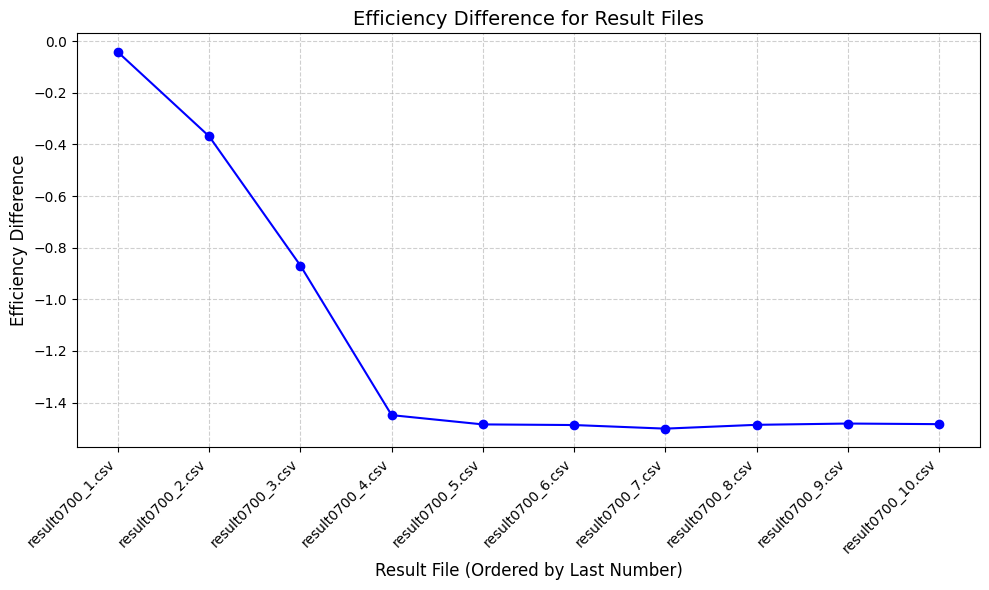

In [ ]:
import matplotlib.ticker as ticker
folder_path = "/content/drive/MyDrive/INFSCI_2125_Final_project/netlogo/0700/"
efficiency_df_0700 = process_network_efficiency(folder_path, weighted_global_efficiency)
plot_efficiency_difference(efficiency_df_0700)

folder_path = "/content/drive/MyDrive/INFSCI_2125_Final_project/netlogo/1000/"
efficiency_df_1000 = process_network_efficiency(folder_path, weighted_global_efficiency)
plot_efficiency_difference(efficiency_df_1000)

folder_path = "/content/drive/MyDrive/INFSCI_2125_Final_project/netlogo/1600/"
efficiency_df_1600 = process_network_efficiency(folder_path, weighted_global_efficiency)
plot_efficiency_difference(efficiency_df_1600)

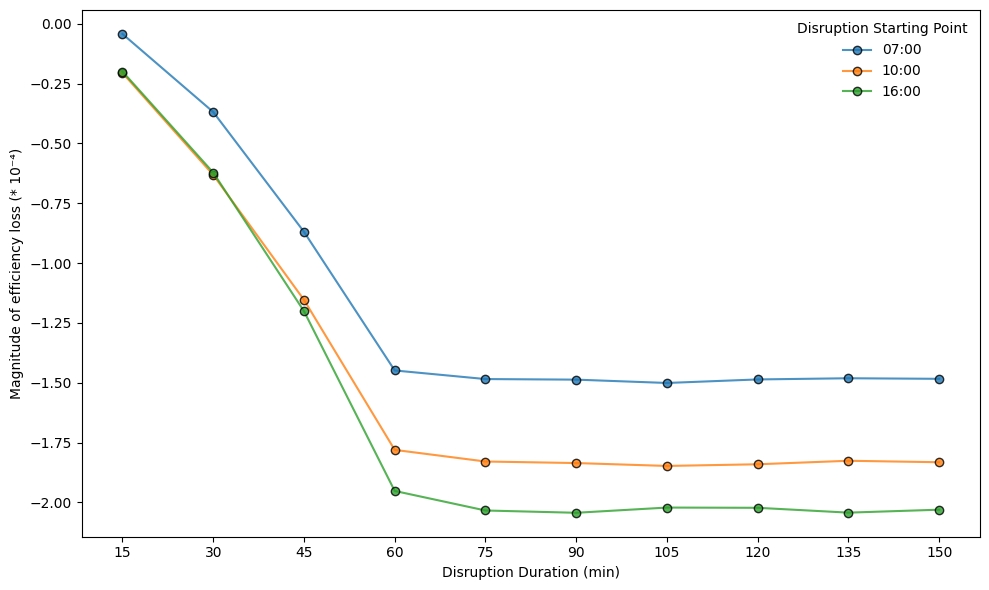

In [ ]:
import matplotlib.pyplot as plt

efficiency_df_0700 = efficiency_df_0700.sort_values(by='File Order')
efficiency_df_1000 = efficiency_df_1000.sort_values(by='File Order')
efficiency_df_1600 = efficiency_df_1600.sort_values(by='File Order')

# plotting
plt.figure(figsize=(10, 6))

# plot 07:00
plt.plot(efficiency_df_0700['File Order'], efficiency_df_0700['Efficiency Difference'],
         marker='o', linestyle='-', label='07:00', alpha=0.8,markeredgecolor='black')

# plot 10:00
plt.plot(efficiency_df_1000['File Order'], efficiency_df_1000['Efficiency Difference'],
         marker='o', linestyle='-', markeredgecolor='black', label='10:00', alpha=0.8)

# plot 16:00
plt.plot(efficiency_df_1600['File Order'], efficiency_df_1600['Efficiency Difference'],
         marker='o', linestyle='-', markeredgecolor='black', label='16:00', alpha=0.8)

plt.xticks(ticks=efficiency_df_0700['File Order'], labels=[15, 30, 45, 60, 75, 90, 105, 120, 135, 150])

plt.xlabel('Disruption Duration (min)')
plt.ylabel('Magnitude of efficiency loss (* 10⁻⁴)')

plt.legend(frameon=False)
plt.legend(title='Disruption Starting Point', frameon=False)

s
plt.tight_layout()
plt.show()